# Random Forest Algorithm with Feedback for Arm-Use Detection

This notebook trains and tests random forest algorithm with output feedback for arm-use detection. The algorithm is trained on the data from the study by Dr Ann David [1].

[1] David, Ann, et al. "Quantification of the relative arm use in patients with hemiparesis using inertial measurement units." Journal of Rehabilitation and Assistive Technologies Engineering 8 (2021): 20556683211019694.

### Getting the data

If you do not already have the data to run this this notebook, 
you need to download it from here.  https://github.com/biorehab/upper-limb-use-assessment



### Standards modules

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy
from scipy import signal
import pathlib
import itertools
import glob
import json

In [3]:
import seaborn as sns

In [4]:
from matplotlib.ticker import MaxNLocator

### Custom Modules

In [9]:
sys.path.append("../scripts")

# import classification_algorithms as ca
# import reduced_models as rm
# import task_analysis as ta

import misc

In [6]:
# import gmac

In [7]:
# Define the font family and size
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.weight'] = 'light'  # Use 'light' font weight


## Define notebook level constants

In [240]:
# Sampling rate for the data is 50ms
dT = 0.02
Fs = int(1 / dT)
DATADIR = "../../gmac/data"
OUTDIR = "../output/"

## Read the Controls and Patients Data

In [233]:
# Read all healthy and patient data.
datadf = misc.read_summarize_data(datadir=DATADIR, dT=dT)

### Generate the autocorrelation function of the UL use data

In [236]:
N = 4000
all_ul_summary = misc.genrate_ul_autocorr_summary(datadf, N=4000)

unaff,  5,  3

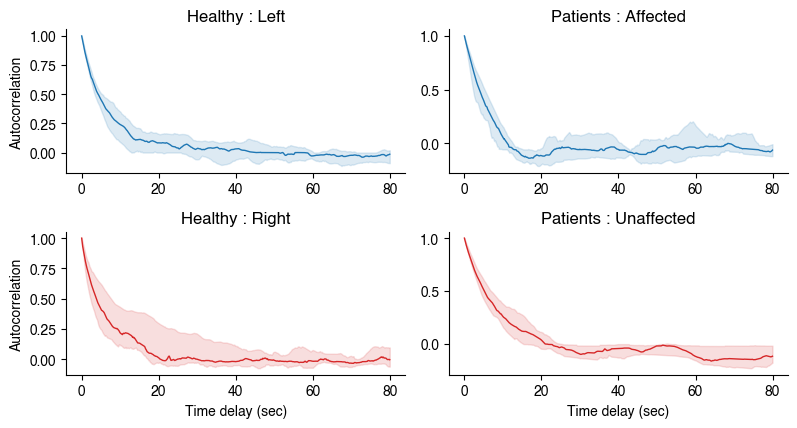

In [242]:
# Summary for healthy subjects
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(421)
_t = np.arange(N) * dT
ax.plot(_t, np.median(all_ul_summary['left'], axis=1), lw=1, color="tab:blue")
q25 = np.percentile(all_ul_summary['left'], 25, axis=1)
q75 = np.percentile(all_ul_summary['left'], 75, axis=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.fill_between(x=_t, y1=q25, y2=q75, color='tab:blue', alpha=0.15)
ax.set_ylabel("Autocorrelation", fontsize=10)
ax.set_title("Healthy : Left", fontsize=12)

ax = fig.add_subplot(423)
ax.plot(_t, np.median(all_ul_summary['right'], axis=1), lw=1, color="tab:red")
q25 = np.percentile(all_ul_summary['right'], 25, axis=1)
q75 = np.percentile(all_ul_summary['right'], 75, axis=1)
ax.fill_between(x=_t, y1=q25, y2=q75, color='tab:red', alpha=0.15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel("Autocorrelation", fontsize=10)
ax.set_xlabel("Time delay (sec)", fontsize=10)
ax.set_title("Healthy : Right", fontsize=12)

ax = fig.add_subplot(422)
_t = np.arange(N_pat) * dT
ax.plot(_t, np.median(all_ul_summary['aff'], axis=1), lw=1, color="tab:blue")
q25 = np.percentile(all_ul_summary['aff'], 25, axis=1)
q75 = np.percentile(all_ul_summary['aff'], 75, axis=1)
ax.fill_between(x=_t, y1=q25, y2=q75, color='tab:blue', alpha=0.15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title("Patients : Affected", fontsize=12)

ax = fig.add_subplot(424)
ax.plot(_t, np.median(all_ul_summary['unaff'], axis=1), lw=1, color="tab:red")
q25 = np.percentile(all_ul_summary['unaff'], 25, axis=1)
q75 = np.percentile(all_ul_summary['unaff'], 75, axis=1)
ax.fill_between(x=_t, y1=q25, y2=q75, color='tab:red', alpha=0.15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Time delay (sec)", fontsize=10)
ax.set_title("Patients : Unaffected", fontsize=12)
plt.tight_layout()

# Save figure
plt.savefig(f"{OUTDIR}/ul_autocorrelation_summary.svg", bbox_inches="tight")
plt.savefig(f"{OUTDIR}/ul_autocorrelation_summary.png", bbox_inches="tight", dpi=300)

### Supporting functions

In [10]:
def compute_confusion_matrix(actual: np.array, estimated: np.array) -> np.array:
    """
    Computes the components of the confusion matrix.
    """
    actual = np.array(actual, dtype=int)
    estimated = np.array(estimated, dtype=int)
    return {
        "TN": np.sum((actual + estimated) == 0), # TN
        "FP": np.sum((1 - actual + estimated) == 2), # FP
        "FN": np.sum((actual + 1 - estimated) == 2), # FN
        "TP": np.sum((actual + estimated) == 2), # TP
    }

## Dual Threshold

#### Parameter ranges for the grid search

In [11]:
basedir = "../data/output-r1-full-new"

# Make directory if it does not exist
outdir = pathlib.Path(basedir, "gmac")
outdir.mkdir(parents=True, exist_ok=True)

# GMAC Parameter ranges
gmac_param_ranges = {
    "np": list(map(int, [1, Fs // 2, Fs])),
    "fc": [0.01, 0.1],
    "nc": [1, 2],
    "nam": list(map(int, [1, Fs // 2, Fs])),
    "p_th": list(range(-90, 100, 10)),
    "p_th_band": list(range(0, 100, 20)),
    "am_th": [0, 0.1, 0.25],
    "am_th_band": [0]
}

# Save params file.
with open(pathlib.Path(outdir, "gmac_params.json"), "w") as f:
    json.dump(gmac_param_ranges, f, indent=4)

In [12]:
dfcols = (["subject"] + list(gmac_param_ranges.keys()) +
            ["limb"] +
            ["TN", "FP", "FN", "TP"] +
            ["TNr", "FPr", "FNr", "TPr"] +
            ["sensitivity", "specificity", "youden"])
gmac_perf_df = pd.DataFrame(columns=dfcols)
for limbkey in ["left", "right", "aff", "unaff"]:
    # Which limb?
    limbdf = datadf[limbkey]
    subjects = limbdf.subject.unique()

    # Estimate pitch for each subject.
    accl_cols = ['ax', 'ay', 'az']

    # Number of all possible combinations
    Ncombs = len(list(misc.generate_param_combinations_gmac(gmac_param_ranges)))

    # All parameter combinations.
    param_combs = list(misc.generate_param_combinations_gmac(gmac_param_ranges))

    for i, subj in enumerate(subjects):
        # Go through all parameter combinations.
        _sinx = limbdf.subject == subj
        for j, _pc in enumerate(param_combs):
            sys.stdout.write(f"\r{limbkey} {i:3d}, {j:3d} / {len(param_combs):3d}")
            df = limbdf[limbdf.subject==subj]
            # Compute gmac
            _gmac = np.hstack([
                gmac.estimate_gmac2(_df[accl_cols].values, accl_farm_inx=0, Fs=Fs,
                                    params=_pc)
                for _, _df in df.groupby('segment')
            ])
            # Compute performance
            _perf = compute_confusion_matrix(actual=df.gnd.values, estimated=_gmac)
            
            # Update gmac df
            _rowdf = pd.DataFrame({"subject": subj} | _pc | _perf, index=[0])
            _rowdf[["TNr", "FPr", "FNr", "TPr"]] = _rowdf[["TN", "FP", "FN", "TP"]] / np.sum(_rowdf[["TN", "FP", "FN", "TP"]].values)
            _rowdf["sensitivity"] = _rowdf.TP / (_rowdf.TP + _rowdf.FN)
            _rowdf["specificity"] = _rowdf.TN / (_rowdf.TN + _rowdf.FP)
            _rowdf["youden"] = _rowdf.sensitivity + _rowdf.specificity - 1
            _rowdf["limb"] = limbkey
            gmac_perf_df = pd.concat(
                (gmac_perf_df, _rowdf),
                ignore_index=True
            )
    # Save data
    gmac_perf_df.to_csv(pathlib.Path(basedir, "gmac", f"perf_gmac.csv").as_posix(), index=False)

unaff   4, 15389 / 15390